In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb

import wandb
from wandb.lightgbm import wandb_callback

pd.set_option("display.max_columns", 181)
pd.set_option("display.min_rows", 200)

In [35]:
#!pip install xgboost

In [36]:
data_dictionary = pd.read_csv("DataDictionaryWiDS2021.csv")
unlabeled = pd.read_csv("UnlabeledWiDS2021.csv")
training = pd.read_csv("TrainingWiDS2021.csv")

In [37]:
column_datatype_mapping = dict(zip(data_dictionary['Variable Name'], data_dictionary['Data Type']))

In [38]:
del training['Unnamed: 0']
del unlabeled['Unnamed: 0']

In [39]:
all_data = training.drop(['encounter_id', 
                          'hospital_id', 
                          'diabetes_mellitus'], axis=1).append(unlabeled)

In [40]:
cat_cols = []
cont_cols = []
for col in all_data.columns:
    if all_data.dtypes[col] == "object":
        cat_cols.append(col)
        all_data[col] = all_data[col].fillna("NA")
        all_data[col] = LabelEncoder().fit_transform(all_data[col])
        all_data[col]= all_data[col].astype('category')
    elif column_datatype_mapping[col] == "binary":
        all_data[col] = all_data[col].fillna(-1)
    elif column_datatype_mapping[col] == "numeric":
        all_data[col] = all_data[col].fillna(0)
        cont_cols.append(col)
    else:
        all_data[col] = all_data[col].fillna(all_data[col].median())
        cont_cols.append(col)

In [41]:
df_train = all_data[:len(training)]
df_pred = all_data[len(training):].reset_index(drop=True)
Y = training['diabetes_mellitus']

In [42]:
X_train, X_val, y_train, y_val = train_test_split(df_train, Y, test_size=0.20, random_state=42,shuffle=True )

In [43]:
xg_train = xgb.DMatrix(X_train.values, label=y_train)
xg_test = xgb.DMatrix(X_val.values, label=y_val)

In [48]:
wandb.init(project="wids_2021", sync_tensorboard=True)
config = wandb.config


param = {'subsample': 1.0, 
         'num_leaves': 10, 
         'min_child_weight': 1, 
         'max_depth': 6, 
         'learning_rate': 0.1, 
         'gamma': 1.5, 
         'colsample_bytree': .6,
         'n_estimators':200,
          'eval_metric':'auc',
          'objective': 'binary:logistic'}

# wandb.config.update(params)

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 300
bst = xgb.train(param, xg_train, num_round, watchlist, callbacks=[wandb.xgboost.wandb_callback()])

# get prediction
pred = bst.predict(xg_test)

train-auc,0.96405
test-auc,0.86741
_step,499
_runtime,39
_timestamp,1610986867


train-auc,▁▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
test-auc,▁▃▄▅▆▆▇▇▇▇██████████████████████████████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████


wandb: wandb version 0.10.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[16:25:30] WARNING: ../src/learner.cc:541: 
Parameters: { n_estimators, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.79859	test-auc:0.78567
[1]	train-auc:0.80706	test-auc:0.79414


/opt/conda/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[2]	train-auc:0.82271	test-auc:0.81012
[3]	train-auc:0.82988	test-auc:0.81672
[4]	train-auc:0.83160	test-auc:0.81887
[5]	train-auc:0.83362	test-auc:0.82060
[6]	train-auc:0.83555	test-auc:0.82233
[7]	train-auc:0.83830	test-auc:0.82528
[8]	train-auc:0.83982	test-auc:0.82691
[9]	train-auc:0.84079	test-auc:0.82804
[10]	train-auc:0.84178	test-auc:0.82876
[11]	train-auc:0.84227	test-auc:0.82939
[12]	train-auc:0.84301	test-auc:0.82991
[13]	train-auc:0.84522	test-auc:0.83166
[14]	train-auc:0.84669	test-auc:0.83299
[15]	train-auc:0.84701	test-auc:0.83313
[16]	train-auc:0.84776	test-auc:0.83356
[17]	train-auc:0.84858	test-auc:0.83431
[18]	train-auc:0.84985	test-auc:0.83508
[19]	train-auc:0.85046	test-auc:0.83582
[20]	train-auc:0.85133	test-auc:0.83637
[21]	train-auc:0.85281	test-auc:0.83736
[22]	train-auc:0.85395	test-auc:0.83794
[23]	train-auc:0.85496	test-auc:0.83861
[24]	train-auc:0.85618	test-auc:0.83942
[25]	train-auc:0.85684	test-auc:0.83969
[26]	train-auc:0.85809	test-auc:0.84078
[27]	tra

In [49]:
#bst.fit(df_train.values, Y.values)

metrics.roc_auc_score(Y.values, bst.predict(xgb.DMatrix(df_train.values)))

0.9269174861531349

In [ ]:
#Basic model final auc: 0.7917882139874278
#0.8263166791535951
#0.8928322559066909
#0.9197601704632955
#0.9458965179388817

In [65]:
pred_proba = bst.predict(xgb.DMatrix(df_pred.values))

#pred_proba = xgbm.predict_proba(df_pred.values)[:,1]]

In [66]:
submittion = pd.DataFrame([unlabeled.encounter_id,pred_proba]).T
submittion.encounter_id = submittion.encounter_id.astype('int32')
submittion.set_index('encounter_id',inplace=True)
submittion.columns = ['diabetes_mellitus']
submittion.fillna(0.5).to_csv('submissions/SolutionWiDS2021_XGB_1000_epochs_best_params_all_data.csv')

## XGB fit on the entire dataset

In [55]:
xg_train = xgb.DMatrix(df_train.values, label=Y)
xg_test = xgb.DMatrix(X_val.values, label=y_val)

In [64]:
wandb.init(project="wids_2021", sync_tensorboard=True)
config = wandb.config


param = {'subsample': 1.0, 
         'num_leaves': 10, 
         'min_child_weight': 1, 
         'max_depth': 6, 
         'learning_rate': 0.1, 
         'gamma': 1.5, 
         'colsample_bytree': .6,
         'n_estimators':1000,
          'eval_metric':'auc',
          'objective': 'binary:logistic',
          'early_stopping_rounds':50}

# wandb.config.update(params)

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 1000
bst = xgb.train(param, xg_train, num_round, watchlist, callbacks=[wandb.xgboost.wandb_callback()])

# get prediction
pred = bst.predict(xg_test)

train-auc,0.95467
test-auc,0.9544
_step,499
_runtime,46
_timestamp,1610988121


train-auc,▁▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
test-auc,▁▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[16:43:14] WARNING: ../src/learner.cc:541: 
Parameters: { early_stopping_rounds, n_estimators, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.79748	test-auc:0.79571
[1]	train-auc:0.80654	test-auc:0.80522
[2]	train-auc:0.82154	test-auc:0.81952
[3]	train-auc:0.82729	test-auc:0.82457
[4]	train-auc:0.83027	test-auc:0.82786
[5]	train-auc:0.83227	test-auc:0.82970
[6]	train-auc:0.83431	test-auc:0.83176
[7]	train-auc:0.83635	test-auc:0.83397
[8]	train-auc:0.83778	test-auc:0.83581
[9]	train-auc:0.83881	test-auc:0.83718
[10]	train-auc:0.83971	test-auc:0.83838
[11]	train-auc:0.84030	test-auc:0.83917
[12]	train-auc:0.84118	test-auc:0.83999
[13]	train-auc:0.84331	test-auc:0.84184
[14]	train-auc:0.84476	test-auc:0.84319
[15]	train-auc:0.84520	test-auc:0.84361
[16

### CV with random hpopt

In [10]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1.5, 3],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [4, 5, 6],
        'num_leaves': [10, 20, 30],
        'learning_rate': [0.01, 0.1, 0.2, 0.4]
        }


In [11]:
xgb = XGBClassifier(n_estimators=200, objective='binary:logistic', verbose=1)

In [18]:
folds = 4
param_comb = 250

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', 
                                   n_jobs=32, cv=skf.split(df_train.values, Y), verbose=3, 
                                   random_state=1001)


In [ ]:
# Here we go
import time
start=time.time()
random_search.fit(df_train.values, Y)
print(time.time()-start)

Fitting 4 folds for each of 250 candidates, totalling 1000 fits


In [20]:
random_search

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f7cb6aeb5d0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                           validate_parameters=None, verbose=1,
                                          

In [22]:
print(random_search.best_params_)

{'subsample': 1.0, 'num_leaves': 10, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 1.5, 'colsample_bytree': 0.6}


In [23]:
pred_proba_rs = random_search.predict_proba(df_pred.values)

In [ ]:
# (pred_proba, pred_proba_rs[:,1])

(array([4852., 1681.,  888.,  690.,  572.,  461.,  417.,  394.,  224.,
          55.]),
 array([7.5848104e-04, 9.6810319e-02, 1.9286215e-01, 2.8891400e-01,
        3.8496581e-01, 4.8101765e-01, 5.7706946e-01, 6.7312133e-01,
        7.6917315e-01, 8.6522502e-01, 9.6127683e-01], dtype=float32),
 <BarContainer object of 10 artists>)

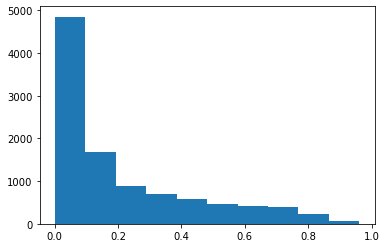

In [24]:
import matplotlib.pyplot as plt
plt.hist(pred_proba_rs[:,1])

In [84]:
submittion = pd.DataFrame([unlabeled.encounter_id,pred_proba_rs[:,1]]).T
submittion.encounter_id = submittion.encounter_id.astype('int32')
submittion.set_index('encounter_id',inplace=True)
submittion.columns = ['diabetes_mellitus']
submittion.fillna(0.5).to_csv('SolutionWiDS2021_XGB_200_epochs_CV_RandomSearch_200runs.csv')